## Load and Compile Game Data

**Importing required libraries and datasets**

In [558]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import os
import missingno as msno
import numpy as np

We can inspect the datasets one at a time to ensure consistent setup. First we get all the datasets for convenience. Tournaments with same letter prefix tend to follow the same data setup.

In [559]:
filenames = []
for (dirpath, dirname, filename) in os.walk('../data/vrd_data/'):
    filenames.extend(filename)
    break
print(*filenames)

cleaned_vrd_data.csv extras.csv VRD Archives - ALEX1.csv VRD Archives - CHI1.csv VRD Archives - CHI2.csv VRD Archives - CHI3.csv VRD Archives - DIS1.csv VRD Archives - DIS10.csv VRD Archives - DIS11.csv VRD Archives - DIS12.csv VRD Archives - DIS13.csv VRD Archives - DIS2.csv VRD Archives - DIS3.csv VRD Archives - DIS4.csv VRD Archives - DIS5.csv VRD Archives - DIS6.csv VRD Archives - DIS8.csv VRD Archives - DIS9.csv VRD Archives - GG1.csv VRD Archives - GG6.csv VRD Archives - MT1.csv VRD Archives - MT2.csv VRD Archives - MT3.csv VRD Archives - NWVRD2.csv VRD Archives - NWVRD3.csv VRD Archives - NWVRD4.csv VRD Archives - NWVRD5.csv VRD Archives - NWVRD6.csv VRD Archives - NWVRD7.csv VRD Archives - NWVRD8.csv VRD Archives - OCL3.csv VRD Archives - PDX1.csv VRD Archives - PDX2.csv VRD Archives - PDX3.csv VRD Archives - PDX4.csv VRD Archives - SFL1.csv VRD Archives - STL6.csv VRD Archives - StLotus1.csv VRD Archives - StLotus2.csv VRD Archives - StLotus3.csv VRD Archives - StLotus4.csv VR

Example preview of a dataset.

In [560]:
df = pd.read_csv('../data/vrd_data/VRD Archives - ALEX1.csv')
df.head()

,Unnamed: 0,JB,JW,AW,DL,JG,SW,MT,AP
0,Wins,2,2,6,5,3,5,1,4
1,Losses,5,5,1,2,4,2,6,3
2,Date,2014-12-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Notes,this came from some guy posting on a forum about his VRD: http://skullheart.com/index.php?threads/magic-the-gathering.6185/page-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Black Lotus,Mox Sapphire,Mox Jet,Mox Pearl,Ancestral Recall,Mox Ruby,Mox Emerald,LIBRARY OF ALEXANDRIA


**Define and populate dataframe colums from the datasets.**

We will add more columns later.

In [561]:
df_clean = pd.DataFrame(columns = ['card_name', 'pick_idx', 'player_idx', 'player_idx_rl', 'round_idx', 'deck_wins', 'deck_losses', 'player_id', 'tournament_id', 'date'])

Due to similar setup we can loop through all of the libraries in order.

In [564]:
for file in os.listdir('../data/vrd_data/'):
    if file.startswith('VRD Archives - '):
        
        # 12 players in this data which would skew the results
        if file == 'VRD Archives - CHI1.csv': continue
        # Different patterns, will skip for now
        elif file == 'VRD Archives - GG6.csv': continue
        elif file == 'VRD Archives - TAN1.csv': continue
        elif file == 'VRD Archives - PDX2.csv': continue
        elif file == 'VRD Archives - SFL1.csv': continue
        #print(file)
        
        # Get tournament id
        tournament_id = file.split(' - ')[1].replace('.csv', '')
        
        tmp_df = pd.read_csv('../data/vrd_data/' + file)
        
        # Get date
        date = tmp_df[tmp_df.iloc[:, 0].str.contains('Date', na=False, case=False)].iloc[:, 1].iloc[-1]                
        
        # Get player ids in an ordered list
        player_ids = list(tmp_df)[1:]
        
        # Get player wins in an ordered list
        wins = tmp_df[tmp_df.iloc[:, 0].str.contains('Wins', na=False, case=False)].iloc[:, 1:].values[0] # unpack double list

        # Get player losses in an ordered list
        losses = tmp_df[tmp_df.iloc[:, 0].str.contains('Losses', na=False, case=False)].iloc[:, 1:].values[0] # unpack double list
        
        # Now we grab the card names and relative indexes. The cards are picked in order from left to right in the first row, 
        # and then every odd row, and from the right to left otherwise for ever numbered rows, following a back and forth pattern.
        # This can be added to the dataframe including the previously obtained data.
        
        # find index of the row with 1 in the first cell, that's where card selection begins
        start_row = tmp_df[tmp_df.iloc[:, 0]=='1'].index.values.astype(int)[0]
        
        # get a slice containing the drafted cards
        cards_df = tmp_df.iloc[start_row:,1:9].reset_index(drop=True)
        cards_df.index += 1 # make index equal to round
        cards_df = cards_df.applymap(lambda s: s.lower().strip() if type(s) == str else s) # shift ro lower case
        
        # Maps to map player_ids to wins, losses, and player_idx
        map_idx = {player_ids[i]: player_ids.index(player_ids[i])+1 for i in range(len(player_ids))}
        map_idx_rl = {player_ids[i]: [8, 7, 6, 5, 4, 3, 2, 1][i] for i in range(len(player_ids))}
        map_wins = {player_ids[i]: wins[i] for i in range(len(player_ids))}
        map_losses = {player_ids[i]: losses[i] for i in range(len(player_ids))}
        
        # Compile pandas DataFrame per dataset
        dfs = cards_df.stack().reset_index() #stack cards according to tournament pick order
        dfs['pick_idx'] = dfs.index + 1 #make pick numbering start from 1
        
        # Misc cleanup
        dfs.rename(columns = {'level_0': 'round_idx', 0: 'card_name', 'level_1': 'player_id'}, inplace = True)
        dfs['tournament_id'] = tournament_id
        dfs['date'] = date
        
        # Mappings
        dfs['player_idx'] = dfs['player_id'].map(map_idx)
        dfs['player_idx_rl'] = dfs['player_id'].map(map_idx_rl)
        dfs['deck_wins'] = dfs['player_id'].map(map_wins)
        dfs['deck_losses'] = dfs['player_id'].map(map_losses)
        
        # Adjust pick order for even rounds (since it goes in the opposite direction)
        dfs.loc[dfs['round_idx']%2 == 0, 'pick_idx'] = (dfs['round_idx']-1)*8+dfs['player_idx_rl']
        
        # Select and organize columns
        dfs = dfs[['card_name', 'pick_idx', 'player_idx', 'player_idx_rl', 'round_idx', 'deck_wins', 'deck_losses', 'player_id', 'tournament_id', 'date']]
        
        # Stack the DataFrames on top of each other
        df_clean = pd.concat([df_clean, dfs.reset_index(drop=True)], axis=0)
        

VRD Archives - ALEX1.csv
VRD Archives - CHI2.csv
VRD Archives - CHI3.csv
VRD Archives - DIS1.csv
VRD Archives - DIS10.csv
VRD Archives - DIS11.csv
VRD Archives - DIS12.csv
VRD Archives - DIS13.csv
VRD Archives - DIS2.csv
VRD Archives - DIS3.csv
VRD Archives - DIS4.csv
VRD Archives - DIS5.csv
VRD Archives - DIS6.csv
VRD Archives - DIS8.csv
VRD Archives - DIS9.csv
VRD Archives - GG1.csv
VRD Archives - MT1.csv
VRD Archives - MT2.csv
VRD Archives - MT3.csv
VRD Archives - NWVRD2.csv
VRD Archives - NWVRD3.csv
VRD Archives - NWVRD4.csv
VRD Archives - NWVRD5.csv
VRD Archives - NWVRD6.csv
VRD Archives - NWVRD7.csv
VRD Archives - NWVRD8.csv
VRD Archives - OCL3.csv
VRD Archives - PDX1.csv
VRD Archives - PDX3.csv
VRD Archives - PDX4.csv
VRD Archives - STL6.csv
VRD Archives - StLotus1.csv
VRD Archives - StLotus2.csv
VRD Archives - StLotus3.csv
VRD Archives - StLotus4.csv
VRD Archives - StLotus5.csv
VRD Archives - StLotus7.csv
VRD Archives - StLotus8.csv
VRD Archives - STLPresents1.csv
VRD Archives 

**Check if everything looks alright so far.**

In [565]:
pd.set_option("display.max_rows", 60, "display.max_columns", None)
df_clean

,card_name,pick_idx,player_idx,player_idx_rl,round_idx,deck_wins,deck_losses,player_id,tournament_id,date
0,black lotus,1,1,8,1,2,5,JB,ALEX1,2014-12-17
1,mox sapphire,2,2,7,1,2,5,JW,ALEX1,2014-12-17
2,mox jet,3,3,6,1,6,1,AW,ALEX1,2014-12-17
3,mox pearl,4,4,5,1,5,2,DL,ALEX1,2014-12-17
4,ancestral recall,5,5,4,1,3,4,JG,ALEX1,2014-12-17
...,...,...,...,...,...,...,...,...,...,...
355,future sight,356,4,5,45,1,2,Alex,YYZ1,2020-04-11
356,"ulamog, the ceaseless hunger",357,5,4,45,0,3,Jacob,YYZ1,2020-04-11
357,secluded steppe,358,6,3,45,2,3,Andrew,YYZ1,2020-04-11
358,seedtime,359,7,2,45,2,4,Freyja,YYZ1,2020-04-11


In [566]:
df_clean.isnull().sum()

card_name        0
pick_idx         0
player_idx       0
player_idx_rl    0
round_idx        0
deck_wins        0
deck_losses      0
player_id        0
tournament_id    0
date             0
dtype: int64

<AxesSubplot:>

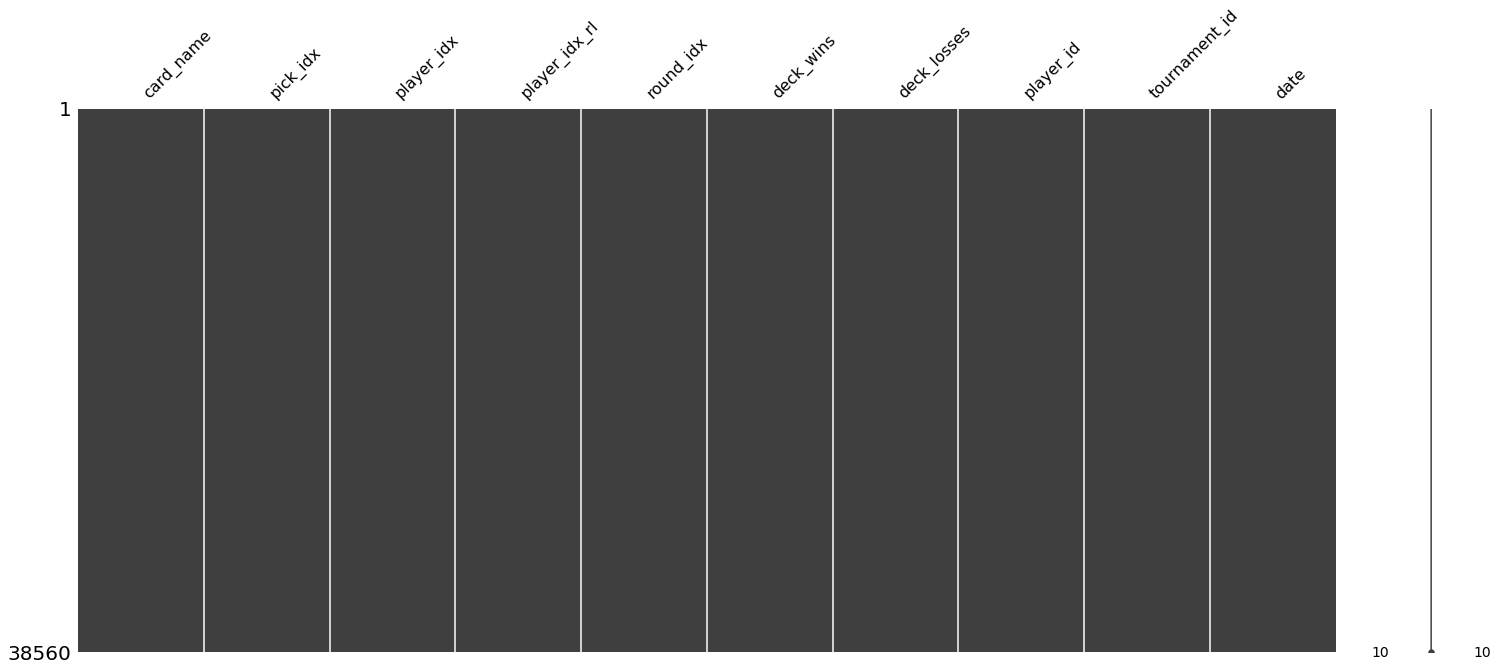

In [567]:
msno.matrix(df_clean)

In [568]:
df_clean.describe()

,card_name,pick_idx,player_idx,player_idx_rl,round_idx,deck_wins,deck_losses,player_id,tournament_id,date
count,38560,38560,38560,38560,38560,38560,38560,38560,38560,38560
unique,2478,368,8,8,46,8,8,223,47,44
top,black lotus,1,1,8,1,4,3,Hyphen-ated,DIS6,2021-10-11
freq,107,107,4820,4820,856,8532,8181,1341,1104,2160


No empty values at this point!

**Save progress**

In [571]:
df.to_csv('../data/cleaned_vrd_data.csv', index=False)

## Parse Scryfall data

**Grab relevant fields of the Scryfall database.**

In [572]:
# This takes a minute to load
df_scry = pd.read_json(DATA_PATH + 'scryfall_data.json', orient='name')
df_scry_small = df_scry[['name', 'type_line', 'mana_cost', 'cmc', 'color_identity', 'legalities']]
df_scry_small.head()

,name,mana_cost,cmc,type_line,color_identity,legalities
0,Fury Sliver,{5}{R},6.0,Creature — Sliver,[R],"{'standard': 'not_legal', 'future': 'not_legal', 'historic': 'not_legal', 'gladiator': 'not_legal', 'pioneer': 'not_legal', 'explorer': 'not_legal', 'modern': 'legal', 'legacy': 'legal', 'pauper': 'not_legal', 'vintage': 'legal', 'penny': 'legal', 'commander': 'legal', 'brawl': 'not_legal', 'historicbrawl': 'not_legal', 'alchemy': 'not_legal', 'paupercommander': 'restricted', 'duel': 'legal', 'oldschool': 'not_legal', 'premodern': 'not_legal'}"
1,Kor Outfitter,{W}{W},2.0,Creature — Kor Soldier,[W],"{'standard': 'not_legal', 'future': 'not_legal', 'historic': 'not_legal', 'gladiator': 'not_legal', 'pioneer': 'not_legal', 'explorer': 'not_legal', 'modern': 'legal', 'legacy': 'legal', 'pauper': 'legal', 'vintage': 'legal', 'penny': 'legal', 'commander': 'legal', 'brawl': 'not_legal', 'historicbrawl': 'not_legal', 'alchemy': 'not_legal', 'paupercommander': 'legal', 'duel': 'legal', 'oldschool': 'not_legal', 'premodern': 'not_legal'}"
2,Spirit,,0.0,Token Creature — Spirit,[W],"{'standard': 'not_legal', 'future': 'not_legal', 'historic': 'not_legal', 'gladiator': 'not_legal', 'pioneer': 'not_legal', 'explorer': 'not_legal', 'modern': 'not_legal', 'legacy': 'not_legal', 'pauper': 'not_legal', 'vintage': 'not_legal', 'penny': 'not_legal', 'commander': 'not_legal', 'brawl': 'not_legal', 'historicbrawl': 'not_legal', 'alchemy': 'not_legal', 'paupercommander': 'not_legal', 'duel': 'not_legal', 'oldschool': 'not_legal', 'premodern': 'not_legal'}"
3,Siren Lookout,{2}{U},3.0,Creature — Siren Pirate,[U],"{'standard': 'not_legal', 'future': 'not_legal', 'historic': 'legal', 'gladiator': 'legal', 'pioneer': 'legal', 'explorer': 'legal', 'modern': 'legal', 'legacy': 'legal', 'pauper': 'legal', 'vintage': 'legal', 'penny': 'legal', 'commander': 'legal', 'brawl': 'not_legal', 'historicbrawl': 'legal', 'alchemy': 'not_legal', 'paupercommander': 'legal', 'duel': 'legal', 'oldschool': 'not_legal', 'premodern': 'not_legal'}"
4,Web,{G},1.0,Enchantment — Aura,[G],"{'standard': 'not_legal', 'future': 'not_legal', 'historic': 'not_legal', 'gladiator': 'not_legal', 'pioneer': 'not_legal', 'explorer': 'not_legal', 'modern': 'legal', 'legacy': 'legal', 'pauper': 'not_legal', 'vintage': 'legal', 'penny': 'not_legal', 'commander': 'legal', 'brawl': 'not_legal', 'historicbrawl': 'not_legal', 'alchemy': 'not_legal', 'paupercommander': 'not_legal', 'duel': 'legal', 'oldschool': 'legal', 'premodern': 'legal'}"


We create a copy of the lowercase name column to match and merge the two datasets.

In [573]:
# Deal with the error message
pd.options.mode.chained_assignment = None  # default='warn'

In [588]:
lower_name = df_scry_small['name'].str.lower()
df_scry_small['card_name'] = lower_name

df_extended = df_clean.merge(df_scry_small, how='left', on='card_name')
df_extended.head()

,card_name,pick_idx,player_idx,player_idx_rl,round_idx,deck_wins,deck_losses,player_id,tournament_id,date,name,mana_cost,cmc,type_line,color_identity,legalities
0,black lotus,1,1,8,1,2,5,JB,ALEX1,2014-12-17,Black Lotus,{0},0.0,Artifact,[],"{'standard': 'not_legal', 'future': 'not_legal', 'historic': 'not_legal', 'gladiator': 'not_legal', 'pioneer': 'not_legal', 'explorer': 'not_legal', 'modern': 'not_legal', 'legacy': 'banned', 'pauper': 'not_legal', 'vintage': 'restricted', 'penny': 'not_legal', 'commander': 'banned', 'brawl': 'not_legal', 'historicbrawl': 'not_legal', 'alchemy': 'not_legal', 'paupercommander': 'not_legal', 'duel': 'banned', 'oldschool': 'restricted', 'premodern': 'not_legal'}"
1,black lotus,1,1,8,1,2,5,JB,ALEX1,2014-12-17,Black Lotus,{0},0.0,Artifact,[],"{'standard': 'not_legal', 'future': 'not_legal', 'historic': 'not_legal', 'gladiator': 'not_legal', 'pioneer': 'not_legal', 'explorer': 'not_legal', 'modern': 'not_legal', 'legacy': 'banned', 'pauper': 'not_legal', 'vintage': 'restricted', 'penny': 'not_legal', 'commander': 'banned', 'brawl': 'not_legal', 'historicbrawl': 'not_legal', 'alchemy': 'not_legal', 'paupercommander': 'not_legal', 'duel': 'banned', 'oldschool': 'not_legal', 'premodern': 'not_legal'}"
2,black lotus,1,1,8,1,2,5,JB,ALEX1,2014-12-17,Black Lotus,{0},0.0,Artifact,[],"{'standard': 'not_legal', 'future': 'not_legal', 'historic': 'not_legal', 'gladiator': 'not_legal', 'pioneer': 'not_legal', 'explorer': 'not_legal', 'modern': 'not_legal', 'legacy': 'banned', 'pauper': 'not_legal', 'vintage': 'restricted', 'penny': 'not_legal', 'commander': 'banned', 'brawl': 'not_legal', 'historicbrawl': 'not_legal', 'alchemy': 'not_legal', 'paupercommander': 'not_legal', 'duel': 'banned', 'oldschool': 'restricted', 'premodern': 'not_legal'}"
3,black lotus,1,1,8,1,2,5,JB,ALEX1,2014-12-17,Black Lotus,{0},0.0,Artifact,[],"{'standard': 'not_legal', 'future': 'not_legal', 'historic': 'not_legal', 'gladiator': 'not_legal', 'pioneer': 'not_legal', 'explorer': 'not_legal', 'modern': 'not_legal', 'legacy': 'banned', 'pauper': 'not_legal', 'vintage': 'restricted', 'penny': 'not_legal', 'commander': 'banned', 'brawl': 'not_legal', 'historicbrawl': 'not_legal', 'alchemy': 'not_legal', 'paupercommander': 'not_legal', 'duel': 'banned', 'oldschool': 'not_legal', 'premodern': 'not_legal'}"
4,black lotus,1,1,8,1,2,5,JB,ALEX1,2014-12-17,Black Lotus,{0},0.0,Artifact,[],"{'standard': 'not_legal', 'future': 'not_legal', 'historic': 'not_legal', 'gladiator': 'not_legal', 'pioneer': 'not_legal', 'explorer': 'not_legal', 'modern': 'not_legal', 'legacy': 'banned', 'pauper': 'not_legal', 'vintage': 'restricted', 'penny': 'not_legal', 'commander': 'banned', 'brawl': 'not_legal', 'historicbrawl': 'not_legal', 'alchemy': 'not_legal', 'paupercommander': 'not_legal', 'duel': 'banned', 'oldschool': 'restricted', 'premodern': 'not_legal'}"


**Clean and sort out the dataset.**

In [592]:
df_extended.rename(columns = {'name': 'card_name_c', 'pick_idx': 'total_pick_idx', 'player_idx': 'player_pick_idx', 'date': 'tournament_date'}, inplace = True)
df_extended.head()

,card_name,total_pick_idx,player_pick_idx,player_idx_rl,round_idx,deck_wins,deck_losses,player_id,tournament_id,tournament_date,card_name_c,mana_cost,cmc,type_line,color_identity,legalities
0,black lotus,1,1,8,1,2,5,JB,ALEX1,2014-12-17,Black Lotus,{0},0.0,Artifact,[],"{'standard': 'not_legal', 'future': 'not_legal', 'historic': 'not_legal', 'gladiator': 'not_legal', 'pioneer': 'not_legal', 'explorer': 'not_legal', 'modern': 'not_legal', 'legacy': 'banned', 'pauper': 'not_legal', 'vintage': 'restricted', 'penny': 'not_legal', 'commander': 'banned', 'brawl': 'not_legal', 'historicbrawl': 'not_legal', 'alchemy': 'not_legal', 'paupercommander': 'not_legal', 'duel': 'banned', 'oldschool': 'restricted', 'premodern': 'not_legal'}"
1,black lotus,1,1,8,1,2,5,JB,ALEX1,2014-12-17,Black Lotus,{0},0.0,Artifact,[],"{'standard': 'not_legal', 'future': 'not_legal', 'historic': 'not_legal', 'gladiator': 'not_legal', 'pioneer': 'not_legal', 'explorer': 'not_legal', 'modern': 'not_legal', 'legacy': 'banned', 'pauper': 'not_legal', 'vintage': 'restricted', 'penny': 'not_legal', 'commander': 'banned', 'brawl': 'not_legal', 'historicbrawl': 'not_legal', 'alchemy': 'not_legal', 'paupercommander': 'not_legal', 'duel': 'banned', 'oldschool': 'not_legal', 'premodern': 'not_legal'}"
2,black lotus,1,1,8,1,2,5,JB,ALEX1,2014-12-17,Black Lotus,{0},0.0,Artifact,[],"{'standard': 'not_legal', 'future': 'not_legal', 'historic': 'not_legal', 'gladiator': 'not_legal', 'pioneer': 'not_legal', 'explorer': 'not_legal', 'modern': 'not_legal', 'legacy': 'banned', 'pauper': 'not_legal', 'vintage': 'restricted', 'penny': 'not_legal', 'commander': 'banned', 'brawl': 'not_legal', 'historicbrawl': 'not_legal', 'alchemy': 'not_legal', 'paupercommander': 'not_legal', 'duel': 'banned', 'oldschool': 'restricted', 'premodern': 'not_legal'}"
3,black lotus,1,1,8,1,2,5,JB,ALEX1,2014-12-17,Black Lotus,{0},0.0,Artifact,[],"{'standard': 'not_legal', 'future': 'not_legal', 'historic': 'not_legal', 'gladiator': 'not_legal', 'pioneer': 'not_legal', 'explorer': 'not_legal', 'modern': 'not_legal', 'legacy': 'banned', 'pauper': 'not_legal', 'vintage': 'restricted', 'penny': 'not_legal', 'commander': 'banned', 'brawl': 'not_legal', 'historicbrawl': 'not_legal', 'alchemy': 'not_legal', 'paupercommander': 'not_legal', 'duel': 'banned', 'oldschool': 'not_legal', 'premodern': 'not_legal'}"
4,black lotus,1,1,8,1,2,5,JB,ALEX1,2014-12-17,Black Lotus,{0},0.0,Artifact,[],"{'standard': 'not_legal', 'future': 'not_legal', 'historic': 'not_legal', 'gladiator': 'not_legal', 'pioneer': 'not_legal', 'explorer': 'not_legal', 'modern': 'not_legal', 'legacy': 'banned', 'pauper': 'not_legal', 'vintage': 'restricted', 'penny': 'not_legal', 'commander': 'banned', 'brawl': 'not_legal', 'historicbrawl': 'not_legal', 'alchemy': 'not_legal', 'paupercommander': 'not_legal', 'duel': 'banned', 'oldschool': 'restricted', 'premodern': 'not_legal'}"


In [ ]:
# split legality by format
# split types and subtypes

In [ ]:
#df_extended = df_extended['card_name', 'total_pick_idx', 'player_pick_idx', 'round_idx', 'deck_wins', 'deck_losses', 'player_id', 'tournament_id', 'tournament_date', 'type', 'color_identity', 'cmc', 'mana_cost', 'legalities']


**Save progress**

In [590]:
df.to_csv(DATA_PATH + '../data/extended_vrd_data.csv', index=False)

# To do
Data Cleaning:
- identify card colours from api
- Include card types and subtypes

EDA:
- pick priority first n rounds
- cards with highest winrate
- best performing colour combinations
- best cards per colour (based on winrate)
- best cards per colour (based on absolute pick order)
- When are lands picked?
- Lands priority order
- Total mana curve

In [434]:
df_clean.loc[df_clean['deck_wins'] == None]
#df.loc[df['card_name']=='seedtime']['round_idx'].hist()
#df.loc[df['card_name']=='duress']['round_idx'].hist()
#df.loc[df['pick_idx']<=2]['card_name'].hist()

,card_name,pick_idx,player_idx,player_idx_rl,round_idx,deck_wins,deck_losses,player_id,tournament_id,date


<AxesSubplot:>

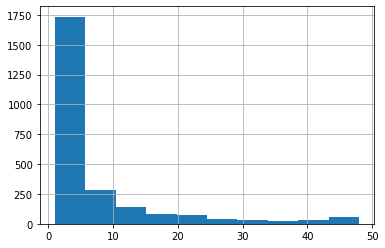